In [1]:
import os, sys, math, gc
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from utils.utils import merge_eval_sold_on_df, sort_df_on_d, WRMSSE, RMSSE, _down_cast, data_preprocessing, diff_lists, log_status #create_submission_df
from utils.utils import customIter

from utils.configure_logger import configure_logger
configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [2]:
DATA_BASE_PATH = '../data/m5-forecasting-accuracy/'
DATA_BASE_PATH_UNCERTAINTY = '../data/m5-forecasting-uncertainty/'
SALES_EVALUATION = 'sales_train_evaluation.csv'
SALES_VALIDATION = 'sales_train_validation.csv'
CALENDAR = 'calendar.csv'
SAMPLE_SUBMISSION = 'sample_submission.csv'
SELL_PRICES = 'sell_prices.csv'

PRECOMPUTED_BASE_PATH = '../data/uncertainty/features/'

DAYS: int = 28
QUANTILES: int = [0.005, 0.025, 0.175, 0.25, 0.50, 0.75, 0.835, 0.975, 0.995]

AGG_LEVEL_COLUMNS = {
    "Level1": [], # no grouping, sum of all
    "Level2": ['state_id'],
    "Level3": ['store_id'],
    "Level4": ['cat_id'],
    "Level5": ['dept_id'],
    "Level6": ['state_id', 'cat_id'],
    "Level7": ['state_id', 'dept_id'],
    "Level8": ['store_id', 'cat_id'],
    "Level9": ['store_id', 'dept_id'],
    "Level10": ['item_id'],
    "Level11": ['state_id', 'item_id'],
    "Level12": ['item_id','store_id'],
}

In [3]:
# read all data
sales_validation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_VALIDATION))
sales_evaluation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_EVALUATION))
calendar: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + CALENDAR))
sample_submission: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SAMPLE_SUBMISSION))
sell_prices: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SELL_PRICES))

### Feature Engineering and Cross Validation

#### Test Runs

In [7]:
# ~25 seconds
df, submission_idx = data_preprocessing(sales_evaluation.iloc[:int(20)], calendar, sell_prices)
df = df[(df.wm_yr_wk > df.release)]
df['id'] = df['id'].astype(str)

In [8]:
df.groupby('id')['sold'].ngroups#.rolling(3).mean()

20

In [27]:
@log_status
def compute_features(df: pd.DataFrame, group_columns):
    feature_columns = []
    # feature_columns += ['sell_price']
    for c in ['id', 'state_id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'sold']:
        if c in df:
            feature_columns += [c]
    
    # precomputing
    df["index"] = df.index
    df["d_int"] = df["d"].apply(lambda x: int(x.split("_")[-1]))
    df["day"] = str(df.date.dt.day)
    
    # to use groupby only once, saves time
    df_grouped = df.groupby(group_columns)
    
    ################################################
    ############### AUTOCORRELATION ################
    ################################################
    PREFIX = 'auto_'
    logger.info('Computing autocorrelation features')
    # DIRECT LAGGED VALUES
    old_columns: set = set(df.columns)
    LAG_SHIFT: int = 28
    for lag in [1, 2, 7, 14, 21]:
        df[PREFIX + f"sold_{lag}"] = df_grouped["sold"].shift(lag+LAG_SHIFT) # 1-day lag
    feature_columns += list(set(df.columns) - old_columns)
    
    # MOVING AVERAGES MEAN
    old_columns: set = set(df.columns)
    for i in [7, 28, 60, 180]:
        df[PREFIX + f'sold_ma_{i}'] = df_grouped['sold'].transform(lambda x: x.shift(LAG_SHIFT).rolling(i).mean()).astype(np.float16)
        df[PREFIX + f'sold_ma_std_{i}'] = df_grouped['sold'].transform(lambda x: x.shift(LAG_SHIFT).rolling(i).std()).astype(np.float16)
    feature_columns += list(set(df.columns) - old_columns)
    
    # ROLLING QUANTILES
    PREFIX = 'autoquantiles_'
    old_columns: set = set(df.columns)
    for quantile in QUANTILES:
        for i in [30, 60, 180]:
            if i // quantile >= 2:
                df[PREFIX + f'sold_ma_{i}_{quantile}'] = df_grouped['sold'].transform(lambda x: x.shift(LAG_SHIFT).rolling(i).quantile(quantile)).astype(np.float16)
    feature_columns += list(set(df.columns) - old_columns)
    
    # # DIFFERENCES
    # old_columns = set(df.columns)
    # feature_columns += list(set(df.columns) - old_columns)
    
    ###############################################
    ############ PRICE AUTOCORRELATION ############ ## ONLY FOR LOWEST AGGREGATION LEVEL USABLE?
    ###############################################
    logger.info('Computing price autocorrelation features')
    # # DIRECT LAGGED VALUES
    # old_columns = set(df.columns)
    # feature_columns += list(set(df.columns) - old_columns)
    
    # # MOVING AVERAGES
    # old_columns = set(df.columns)
    # feature_columns += list(set(df.columns) - old_columns)
    
    # # EXPONENTIAL SMOOTHING AVERAGES
    # old_columns = set(df.columns)
    # feature_columns += list(set(df.columns) - old_columns)
    
    # PRICE DIFFERENCES
    # PREFIX = 'momentum_'
    # old_columns = set(df.columns)
    # df[PREFIX + 'sell_price_w'] = df['sell_price'] / df.groupby(['id', 'wm_yr_wk'])['sell_price'].transform(lambda x: x.shift(1))
    # df[PREFIX + 'sell_price_m'] = df['sell_price'] / df.groupby(['id', 'year', 'month'])['sell_price'].transform(lambda x: x.shift(1))
    # df[PREFIX + 'sell_price_y'] = df['sell_price'] / df.groupby(['id', 'year'])['sell_price'].transform(lambda x: x.shift(1))
    # feature_columns += list(set(df.columns) - old_columns)

    ################################################
    ############ PRODUCT CHARACTERISTICS ###########
    ################################################
    logger.info('Computing unconditional sold values')
    # UNCONDITIONAL SALES
    PREFIX = 'unconditional_'
    # old_columns = set(df.columns)
    # df['sold_mean'] = df.groupby(['id'])['sold'].transform(lambda x: x.mean())
    # df['sold_std'] = df.groupby(['id'])['sold'].transform(lambda x: x.std())
    # df['sold_max'] = df.groupby(['id'])['sold'].transform(lambda x: x.max())
    # feature_columns += list(set(df.columns) - old_columns)
    
    # old_columns = set(df.columns)    
    # icols =  [
    #     ['state_id'],
    #     ['store_id'],
    #     ['cat_id'],
    #     ['dept_id'],
    #     ['state_id', 'cat_id'],
    #     ['state_id', 'dept_id'],
    #     ['store_id', 'cat_id'],
    #     ['store_id', 'dept_id'],
    #     ['item_id'],
    #     ['item_id', 'state_id'],
    #     ['item_id', 'store_id']
    # ]
    # for col in icols:
    #     col_name = '_'+'_'.join(col)+'_'
    #     df[PREFIX + 'sold'+col_name+'median'] = df.groupby(col)['sold'].transform('median').astype(np.float16)
    #     df[PREFIX + 'sold'+col_name+'mean'] = df.groupby(col)['sold'].transform('mean').astype(np.float16)
    #     df[PREFIX + 'sold'+col_name+'std'] = df.groupby(col)['sold'].transform('std').astype(np.float16)
    # feature_columns += list(set(df.columns) - old_columns)

    ################################################
    ############## SEASONAL FEATURES ###############
    ################################################
    logger.info('Encoding date features to dummies')
    PREFIX = 'seasonal_'
    # WEEK / MONTH DUMMIES
    encode_columns = ['weekday', 'month']
    old_columns = set(df.columns)
    df = pd.get_dummies(df, columns = encode_columns, prefix=PREFIX, prefix_sep='')
    feature_columns += list(set(df.columns) - old_columns)
    
    # for day, no dummy encoding
    df['seasonal_d_int'] = df['d_int']
    feature_columns += ['seasonal_d_int']
    
    # return final results
    df = _down_cast(df)
    return df[feature_columns]

In [28]:
# total ~77 seconds
df['temp_id'] = 'temp_id'
agg_columns = ['temp_id']
agg_dict = {
    'sold': np.nansum,
    'date': 'last',
    'weekday': 'last',
    'month': 'last'
}
features = compute_features(
    df.groupby(agg_columns + ['d']).agg(agg_dict).reset_index(drop=False),
    ['temp_id']
)
        
# # test for id grouping
# features = compute_features(df.copy(), ['id'])
# print(features.shape)

2023-08-16 22:59:09 - compute_features - INFO - calling
2023-08-16 22:59:09 - __main__ - INFO - Computing autocorrelation features
2023-08-16 22:59:09 - __main__ - INFO - Computing price autocorrelation features
2023-08-16 22:59:09 - __main__ - INFO - Computing unconditional sold values
2023-08-16 22:59:09 - __main__ - INFO - Encoding date features to dummies


<Axes: >

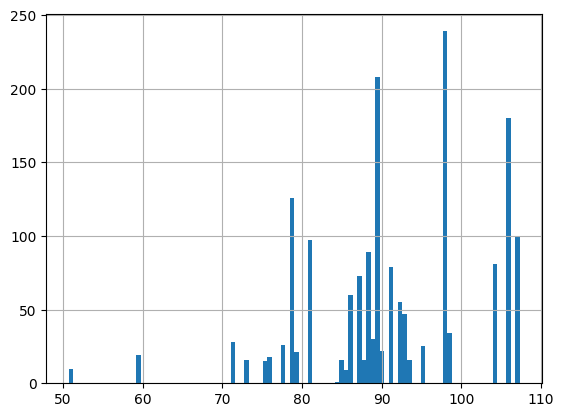

In [29]:
features['autoquantiles_sold_ma_180_0.995'].hist(bins=100)

In [13]:
# features[features['id'] == 'HOBBIES_1_008_CA_1_evaluation'][['sold', 'auto_sold_ma_7', 'auto_sold_ma_21', 'auto_sold_ma_60']].plot()

In [30]:
spaces = 5
for i in range(0,len(features.columns), spaces):
    print('_'.join(list(features.columns)[i:i+spaces]))

d_sold_auto_sold_7_auto_sold_2_auto_sold_1
auto_sold_21_auto_sold_14_auto_sold_ma_std_28_auto_sold_ma_std_180_auto_sold_ma_std_60
auto_sold_ma_60_auto_sold_ma_180_auto_sold_ma_std_7_auto_sold_ma_7_auto_sold_ma_28
autoquantiles_sold_ma_60_0.25_autoquantiles_sold_ma_30_0.995_autoquantiles_sold_ma_30_0.835_autoquantiles_sold_ma_180_0.995_autoquantiles_sold_ma_60_0.005
autoquantiles_sold_ma_60_0.025_autoquantiles_sold_ma_60_0.835_autoquantiles_sold_ma_30_0.175_autoquantiles_sold_ma_180_0.975_autoquantiles_sold_ma_60_0.5
autoquantiles_sold_ma_30_0.025_autoquantiles_sold_ma_180_0.5_autoquantiles_sold_ma_30_0.5_autoquantiles_sold_ma_180_0.25_autoquantiles_sold_ma_30_0.975
autoquantiles_sold_ma_60_0.975_autoquantiles_sold_ma_30_0.005_autoquantiles_sold_ma_180_0.025_autoquantiles_sold_ma_180_0.005_autoquantiles_sold_ma_60_0.75
autoquantiles_sold_ma_180_0.835_autoquantiles_sold_ma_30_0.25_autoquantiles_sold_ma_180_0.175_autoquantiles_sold_ma_60_0.995_autoquantiles_sold_ma_60_0.175
autoquantiles_

### Final Runs for Validation and Evaluation

In [31]:
@log_status
def groupby_agglevel(df: pd.DataFrame, agg_columns: list, agg_dict: dict):
    return df.groupby(agg_columns).agg(agg_dict).reset_index(drop=False)

In [26]:
# pivot initial dataframe and compute features/targets
df_val, submission_idx_validation = data_preprocessing(sales_validation, calendar, sell_prices)
df_val_after_release = df_val[(df_val.wm_yr_wk > df_val.release)]
del df_val

In [33]:
TEST_RUN = False
for agg_level in AGG_LEVEL_COLUMNS:
    agg_columns = AGG_LEVEL_COLUMNS[agg_level]
    # get data on aggregated level
    if len(agg_columns) == 0:
        df_val_after_release['temp_id'] = 'temp_id'
        agg_columns = ['temp_id']
    agg_dict = {
        'sold': np.nansum,
        'date': 'last',
        'weekday': 'last',
        'month': 'last'
    }
    features = compute_features(
        groupby_agglevel(df_val_after_release, agg_columns + ['d'], agg_dict),
        agg_columns
    )
    
    # to suitable format for .parquet
    for c in features.columns:
        if c not in ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'state_id']:
            features[c] = features[c].astype(np.float32)
        
    # format string and save file
    n = len(agg_columns)
    if n == 0: 
        agg_string = 'Total_X'
    elif n == 1:
        agg_string = f'{agg_columns[0]}_X'
    else:
        agg_string = '_'.join(agg_columns)
    if not TEST_RUN:
        features.to_parquet(PRECOMPUTED_BASE_PATH + f'features_val_{agg_string}.parquet', index=False)
        del features
    else:
        features.to_parquet(PRECOMPUTED_BASE_PATH + f'/test/features_val_{agg_string}.parquet', index=False)
        
if not TEST_RUN: 
    del df_val_after_release

2023-08-16 23:01:36 - groupby_agglevel - INFO - calling
2023-08-16 23:01:41 - compute_features - INFO - calling
2023-08-16 23:01:41 - __main__ - INFO - Computing autocorrelation features
2023-08-16 23:01:41 - __main__ - INFO - Computing price autocorrelation features
2023-08-16 23:01:41 - __main__ - INFO - Computing unconditional sold values
2023-08-16 23:01:41 - __main__ - INFO - Encoding date features to dummies
2023-08-16 23:01:41 - groupby_agglevel - INFO - calling
2023-08-16 23:01:44 - compute_features - INFO - calling
2023-08-16 23:01:44 - __main__ - INFO - Computing autocorrelation features
2023-08-16 23:01:44 - __main__ - INFO - Computing price autocorrelation features
2023-08-16 23:01:44 - __main__ - INFO - Computing unconditional sold values
2023-08-16 23:01:44 - __main__ - INFO - Encoding date features to dummies
2023-08-16 23:01:44 - groupby_agglevel - INFO - calling
2023-08-16 23:01:48 - compute_features - INFO - calling
2023-08-16 23:01:48 - __main__ - INFO - Computing au

In [35]:
# pivot initial dataframe and compute features/targets
df_eval, submission_idx_validation = data_preprocessing(sales_evaluation, calendar, sell_prices)
df_eval_after_release = df_eval[(df_eval.wm_yr_wk > df_eval.release)]
del df_eval

In [36]:
TEST_RUN = False
for agg_level in AGG_LEVEL_COLUMNS:
    agg_columns = AGG_LEVEL_COLUMNS[agg_level]
    # get data on aggregated level
    if len(agg_columns) == 0:
        df_eval_after_release['temp_id'] = 'temp_id'
        agg_columns = ['temp_id']
    agg_dict = {
        'sold': np.nansum,
        'date': 'last',
        'weekday': 'last',
        'month': 'last'
    }
    features = compute_features(
        groupby_agglevel(df_eval_after_release, agg_columns + ['d'], agg_dict),
        agg_columns
    )
    
    # to suitable format for .parquet
    for c in features.columns:
        if c not in ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'state_id']:
            features[c] = features[c].astype(np.float32)
        
    # format string and save file
    n = len(agg_columns)
    if n == 0: 
        agg_string = 'Total_X'
    elif n == 1:
        agg_string = f'{agg_columns[0]}_X'
    else:
        agg_string = '_'.join(agg_columns)
    if not TEST_RUN:
        features.to_parquet(PRECOMPUTED_BASE_PATH + f'features_eval_{agg_string}.parquet', index=False)
        del features
    else:
        features.to_parquet(PRECOMPUTED_BASE_PATH + f'/test/features_eval_{agg_string}.parquet', index=False)
        
if not TEST_RUN: 
    del df_eval_after_release

2023-08-16 23:57:44 - groupby_agglevel - INFO - calling
2023-08-16 23:57:49 - compute_features - INFO - calling
2023-08-16 23:57:49 - __main__ - INFO - Computing autocorrelation features
2023-08-16 23:57:49 - __main__ - INFO - Computing price autocorrelation features
2023-08-16 23:57:49 - __main__ - INFO - Computing unconditional sold values
2023-08-16 23:57:49 - __main__ - INFO - Encoding date features to dummies
2023-08-16 23:57:49 - groupby_agglevel - INFO - calling
2023-08-16 23:57:52 - compute_features - INFO - calling
2023-08-16 23:57:52 - __main__ - INFO - Computing autocorrelation features
2023-08-16 23:57:52 - __main__ - INFO - Computing price autocorrelation features
2023-08-16 23:57:52 - __main__ - INFO - Computing unconditional sold values
2023-08-16 23:57:52 - __main__ - INFO - Encoding date features to dummies
2023-08-16 23:57:52 - groupby_agglevel - INFO - calling
2023-08-16 23:57:55 - compute_features - INFO - calling
2023-08-16 23:57:55 - __main__ - INFO - Computing au